## Task 1:Data Warehousing Design

In [29]:
import sqlite3
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# =============================================
# STEP 1: Generate Synthetic Dimension Tables
# =============================================

# --- dim_product ---
categories = ['Electronics', 'Clothing', 'Home Appliances', 'Books']
products = []
for i in range(1, 101):  # 100 products
    products.append({
        'product_id': i,
        'product_name': f'Product_{i}',
        'category': np.random.choice(categories),
        'price': round(np.random.uniform(10, 500), 2),
        'supplier_id': np.random.randint(1, 11)  # 10 suppliers
    })
df_product = pd.DataFrame(products)

# --- dim_customer ---
cities = ['New York', 'Los Angeles', 'Chicago', 'Houston', 'Miami']
customers = []
for i in range(1, 51):  # 50 customers
    customers.append({
        'customer_id': i,
        'customer_name': f'Customer_{i}',
        'age': np.random.randint(18, 70),
        'gender': np.random.choice(['M', 'F']),
        'city': np.random.choice(cities),
        'loyalty_status': np.random.choice(['Gold', 'Silver', 'Bronze'], p=[0.2, 0.3, 0.5])
    })
df_customer = pd.DataFrame(customers)

# --- dim_time ---
dates = pd.date_range(start='2023-01-01', end='2024-12-31')  # 2 years of data
time_data = []
for i, date in enumerate(dates):
    time_data.append({
        'time_id': i + 1,
        'date': date.strftime('%Y-%m-%d'),
        'day_of_week': date.strftime('%A'),
        'month': date.month,
        'quarter': (date.month - 1) // 3 + 1,
        'year': date.year
    })
df_time = pd.DataFrame(time_data)

# =============================================
# STEP 2: Generate Fact Table (fact_sales)
# =============================================
sales = []
for i in range(1, 1001):  # 1000 sales records
    sales.append({
        'sale_id': i,
        'product_id': np.random.randint(1, 101),
        'customer_id': np.random.randint(1, 51),
        'time_id': np.random.randint(1, len(dates) + 1),
        'quantity': np.random.randint(1, 5),
        'total_amount': round(np.random.uniform(20, 1000), 2),
        'discount': round(np.random.uniform(0, 0.3), 2)  # 0-30% discount
    })
df_sales = pd.DataFrame(sales)

# =============================================
# STEP 3: Load Data into SQLite Database
# =============================================
conn = sqlite3.connect('retail_data_warehouse.db')
cursor = conn.cursor()

# Execute the SQL CREATE TABLE statements (from Task 1)
cursor.executescript('''
DROP TABLE IF EXISTS fact_sales;
DROP TABLE IF EXISTS dim_product;
DROP TABLE IF EXISTS dim_customer;
DROP TABLE IF EXISTS dim_time;

CREATE TABLE dim_product (
    product_id INTEGER PRIMARY KEY,
    product_name TEXT NOT NULL,
    category TEXT NOT NULL,
    price REAL,
    supplier_id INTEGER
);

CREATE TABLE dim_customer (
    customer_id INTEGER PRIMARY KEY,
    customer_name TEXT NOT NULL,
    age INTEGER,
    gender TEXT,
    city TEXT,
    loyalty_status TEXT
);

CREATE TABLE dim_time (
    time_id INTEGER PRIMARY KEY,
    date DATE NOT NULL,
    day_of_week TEXT,
    month INTEGER,
    quarter INTEGER,
    year INTEGER
);

CREATE TABLE fact_sales (
    sale_id INTEGER PRIMARY KEY,
    product_id INTEGER,
    customer_id INTEGER,
    time_id INTEGER,
    quantity INTEGER,
    total_amount REAL,
    discount REAL,
    FOREIGN KEY (product_id) REFERENCES dim_product(product_id),
    FOREIGN KEY (customer_id) REFERENCES dim_customer(customer_id),
    FOREIGN KEY (time_id) REFERENCES dim_time(time_id)
);
''')

# Insert data into tables
df_product.to_sql('dim_product', conn, if_exists='append', index=False)
df_customer.to_sql('dim_customer', conn, if_exists='append', index=False)
df_time.to_sql('dim_time', conn, if_exists='append', index=False)
df_sales.to_sql('fact_sales', conn, if_exists='append', index=False)

conn.commit()
conn.close()

print("Data generation and SQLite loading complete!")

Data generation and SQLite loading complete!


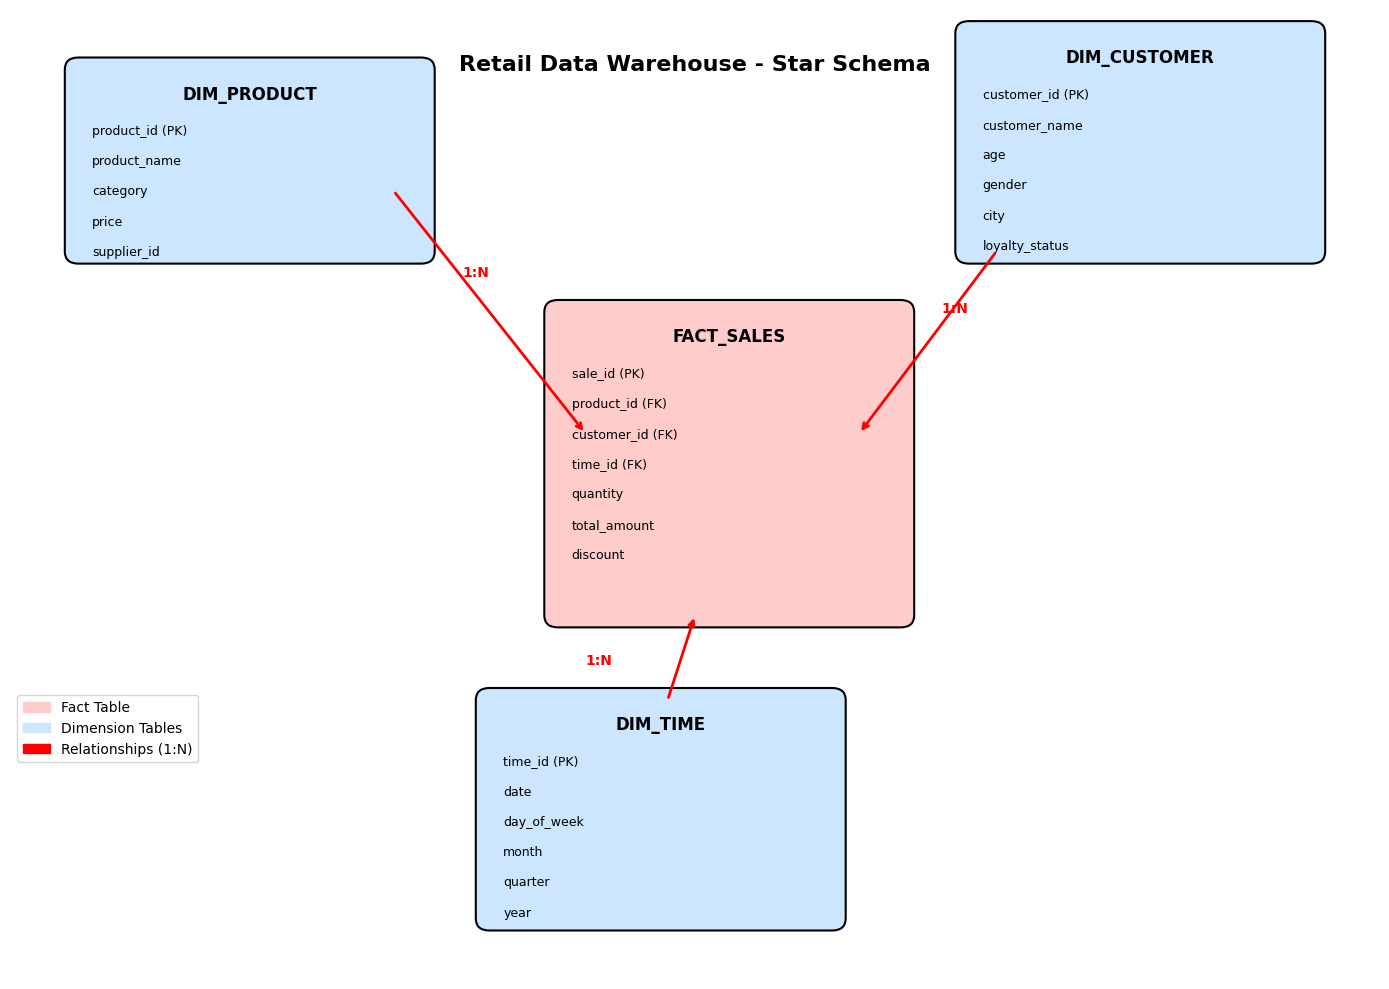

Star schema diagram saved as star_schema.png


In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch

# Create star schema diagram using matplotlib
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
ax.set_xlim(0, 10)
ax.set_ylim(0, 8)
ax.axis('off')

# Define colors
fact_color = '#ffcccc'
dim_color = '#cce6ff'

# Function to create table boxes
def create_table_box(ax, x, y, width, height, title, columns, color):
    # Main box
    box = FancyBboxPatch((x, y), width, height, 
                         boxstyle="round,pad=0.1", 
                         facecolor=color, 
                         edgecolor='black', 
                         linewidth=1.5)
    ax.add_patch(box)
    
    # Title
    ax.text(x + width/2, y + height - 0.2, title, 
            fontsize=12, fontweight='bold', 
            ha='center', va='center')
    
    # Columns
    for i, col in enumerate(columns):
        ax.text(x + 0.1, y + height - 0.5 - (i * 0.25), col, 
                fontsize=9, ha='left', va='center')

# Fact table (center)
fact_columns = [
    'sale_id (PK)',
    'product_id (FK)',
    'customer_id (FK)', 
    'time_id (FK)',
    'quantity',
    'total_amount',
    'discount'
]
create_table_box(ax, 4, 3, 2.5, 2.5, 'FACT_SALES', fact_columns, fact_color)

# Dimension tables
# dim_product (top left)
product_columns = [
    'product_id (PK)',
    'product_name',
    'category',
    'price',
    'supplier_id'
]
create_table_box(ax, 0.5, 6, 2.5, 1.5, 'DIM_PRODUCT', product_columns, dim_color)

# dim_customer (top right)
customer_columns = [
    'customer_id (PK)',
    'customer_name',
    'age',
    'gender',
    'city',
    'loyalty_status'
]
create_table_box(ax, 7, 6, 2.5, 1.8, 'DIM_CUSTOMER', customer_columns, dim_color)

# dim_time (bottom)
time_columns = [
    'time_id (PK)',
    'date',
    'day_of_week',
    'month',
    'quarter',
    'year'
]
create_table_box(ax, 3.5, 0.5, 2.5, 1.8, 'DIM_TIME', time_columns, dim_color)

# Draw relationships (arrows)
# Product to Fact
ax.annotate('', xy=(4.2, 4.5), xytext=(2.8, 6.5),
            arrowprops=dict(arrowstyle='->', lw=2, color='red'))
ax.text(3.3, 5.8, '1:N', fontsize=10, fontweight='bold', color='red')

# Customer to Fact
ax.annotate('', xy=(6.2, 4.5), xytext=(7.2, 6),
            arrowprops=dict(arrowstyle='->', lw=2, color='red'))
ax.text(6.8, 5.5, '1:N', fontsize=10, fontweight='bold', color='red')

# Time to Fact
ax.annotate('', xy=(5, 3), xytext=(4.8, 2.3),
            arrowprops=dict(arrowstyle='->', lw=2, color='red'))
ax.text(4.2, 2.6, '1:N', fontsize=10, fontweight='bold', color='red')

# Title
ax.text(5, 7.5, 'Retail Data Warehouse - Star Schema', 
        fontsize=16, fontweight='bold', ha='center')

# Legend
legend_elements = [
    patches.Patch(color=fact_color, label='Fact Table'),
    patches.Patch(color=dim_color, label='Dimension Tables'),
    patches.Patch(color='red', label='Relationships (1:N)')
]
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0, 0.3))

plt.tight_layout()
plt.savefig('star_schema.png', dpi=300, bbox_inches='tight')
plt.show()
print("Star schema diagram saved as star_schema.png")

# Verify Data in DB browser

In [30]:
import sqlite3
conn = sqlite3.connect('retail_data_warehouse.db')
pd.read_sql_query("SELECT * FROM fact_sales LIMIT 5", conn)

,sale_id,product_id,customer_id,time_id,quantity,total_amount,discount
0,1,92,29,497,4,781.31,0.10
1,2,69,32,583,3,568.41,0.24
2,3,11,27,408,3,388.93,0.08
3,4,26,50,527,3,355.94,0.21
4,5,42,26,183,2,391.09,0.28
